In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def angular_spectrum_propagation_free_space(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U1  : the propagated field

    Implemented according to: 
    Matsushima, Kyoji, and Tomoyoshi Shimobaba. 
    "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." 
    Optics express 17.22 (2009): 19662-19673.
    """

    # Get the shape of the original array
    original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2
    # Create a new array filled with zeros with the target shape
    U0_padded = np.zeros((original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype)
    # Place the original array in the center of the new array
    U0_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0
    
    # Get array size
    ny, nx = U0_padded.shape
    # Wave number
    k = 2 * np.pi / wvl 

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)

    Delta_uy =  1 / (ny * dx)
    Delta_ux =  1 / (nx * dx)
    u_limity = 1 / (np.sqrt((2 * Delta_uy * z)**2 + 1) * wvl)
    u_limitx = 1 / (np.sqrt((2 * Delta_ux * z)**2 + 1) * wvl)
    H_limit = W = ((FY**2 / u_limity**2 + FX**2 * wvl**2) < 1) * ((FX**2 / u_limitx**2 + FY**2 * wvl**2) < 1)
    # Kernel
    H = np.exp(1j * k * z * np.sqrt(0j + 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # propagate
    U1_padded = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(np.fft.ifftshift(U0_padded)) * H * H_limit))
    # extract to initial size
    U1 = U1_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width]
          
    return U1


# Coherent Propagation

Propagate `U0` first a free space propagation of `z`. Then multiply with the aperture. Propagate another free flight propagation of distance `z`.
What do you observe for the coherent propagation?
Propagate for `z=40µm` and `z=400µm`.

In [6]:
dx = 2e-6
N = 70
z = 40e-6
wvl = 633e-9

x = np.linspace(-N / 2 * dx, N / 2  * dx, N, endpoint=False)
y = x
X, Y = np.meshgrid(x,y)

U0 = np.ones((N, N))
aperture = ((np.abs(X-10e-6) < 3e-6) + (np.abs(X+10e-6) < 3e-6)) * (np.abs(Y) < 100e-6)

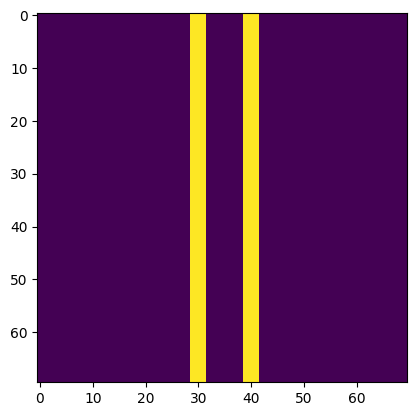

In [7]:
plt.imshow(aperture)

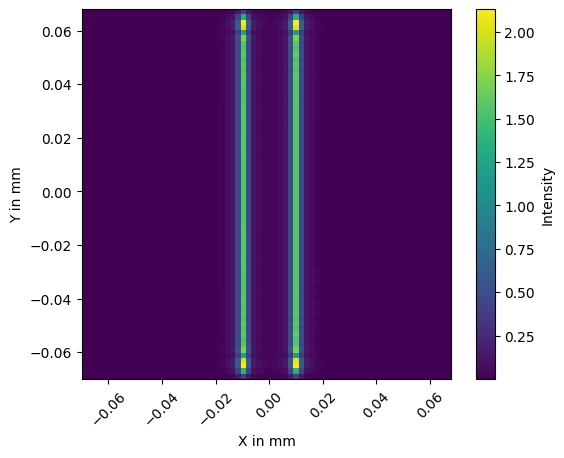

In [17]:
U_prop = angular_spectrum_propagation_free_space(angular_spectrum_propagation_free_space(U0, wvl, dx, z) * aperture, wvl, dx, z)

plt.imshow(np.abs(U_prop)**2, extent=[x.min() * 1000, x.max() * 1000, y.min() * 1000, y.max() * 1000])
plt.colorbar(label="Intensity")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)

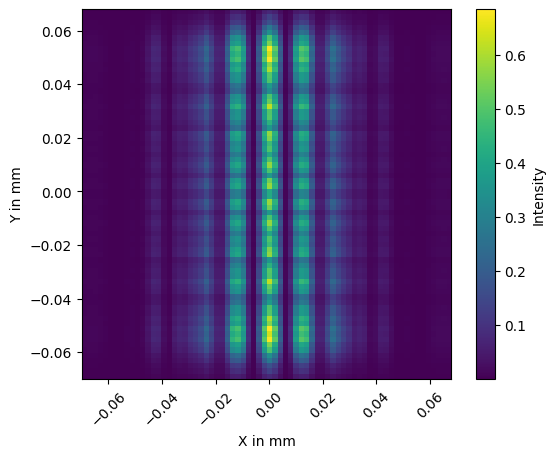

In [9]:
U_prop = angular_spectrum_propagation_free_space(angular_spectrum_propagation_free_space(U0, wvl, dx, 400e-6) * aperture, wvl, dx, 400e-6)

plt.imshow(np.abs(U_prop)**2, extent=[x.min() * 1000, x.max() * 1000, y.min() * 1000, y.max() * 1000])
plt.colorbar(label="Intensity")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)

# Incoherent Propagation

Simulate the same scenario now, however we want to simulate incoherent light. 
So what do you need to change? 

*Hint: A single coherent propagation is not enough, you need to add many intensities of simulations together (> 100)*.

In [13]:
def incoherent(U, aperture, wvl, dx, z, M=100):
    
    final_intensity = 0.0 * U
    
    for i in range(M):
        U_r = np.exp(1j * 2 * np.pi * (np.random.rand(U.shape[0], U.shape[1]))) * U
        U1 = angular_spectrum_propagation_free_space(U_r, wvl, dx, z)
        Uf = angular_spectrum_propagation_free_space(U1 * aperture, wvl, dx, z)
        final_intensity += np.abs(Uf)**2

    return final_intensity

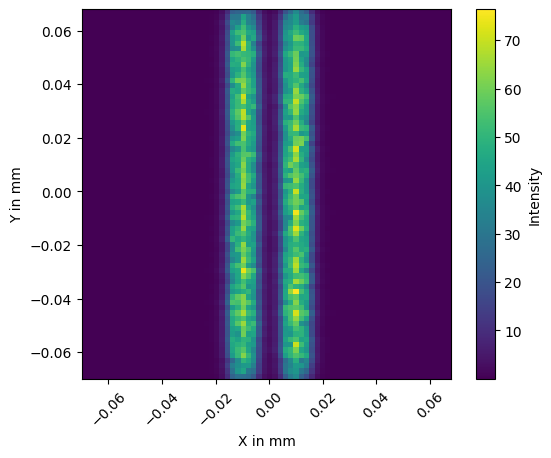

In [14]:
I_incoherent = incoherent(U0, aperture, wvl, dx, 40e-6, 100)
plt.imshow(I_incoherent, extent=[x.min() * 1000, x.max() * 1000, y.min() * 1000, y.max() * 1000])
plt.colorbar(label="Intensity")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)

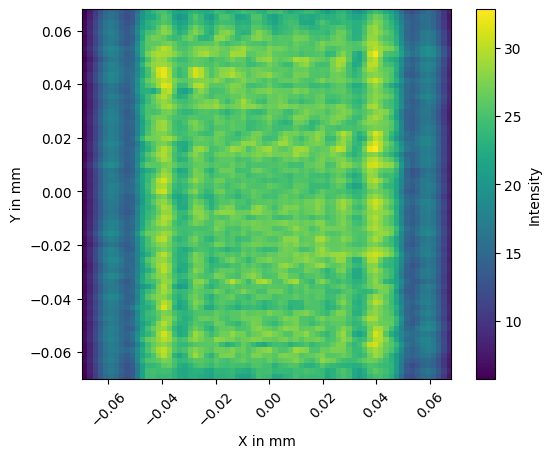

In [15]:
I_incoherent = incoherent(U0, aperture, wvl, dx, 400e-6, 500)
plt.imshow(I_incoherent, extent=[x.min() * 1000, x.max() * 1000, y.min() * 1000, y.max() * 1000])
plt.colorbar(label="Intensity")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)